In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.transforms import blended_transform_factory
import shutil
import pandas as pd
import numpy as np
import ast

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Read all category csv files

In [3]:
topic_csv_dir = "topic_csv"

all_data_df = pd.read_csv(f"{topic_csv_dir}/all_results.csv")
print(f"Loaded file {topic_csv_dir}/all_results.csv with shape {all_data_df.shape}")
# convert Image column value to string
all_data_df["Image"] = all_data_df["Image"].astype(str)

# list all csv files in the directory
csv_files = [f for f in os.listdir(topic_csv_dir) if f != "all_results.csv"]
print(f"Now:, concatenating: {csv_files}")

# read all csv files and concatenate them into one dataframe
all_topic_df = pd.concat([pd.read_csv(os.path.join(topic_csv_dir, f)) for f in csv_files])
all_topic_df["Image"] = all_topic_df["Image"].astype(str)
print(f"Concatenated all csv files into one dataframe with shape {all_topic_df.shape}")

Loaded file topic_csv/all_results.csv with shape (60440, 37)
Now:, concatenating: ['N. Economy and work.csv', 'M. Race and ethnicity.csv', 'Q. Security.csv', 'J. News habits and media.csv', 'D. Politics and policy.csv', 'E. Demographics.csv', 'C. Science and technology.csv', 'L. Family and relationships.csv', 'G. International affairs.csv', 'A. Social values and attitudes.csv', 'I. Gender and LGBTQ.csv', 'B. Religion and spirituality.csv', 'O. Regions and countries.csv', 'K. Immigration and migration.csv', 'P. Methodological research.csv']
Concatenated all csv files into one dataframe with shape (60440, 37)


In [4]:
unique_questions_df = all_topic_df[all_topic_df['Image'] == 'True'][['question_topic', 'question_text', 'md_sim_topic', 'question_topic_mean_similarity','question_topic_country_mean_similarity', 'country']].drop_duplicates()
unique_questions_df = unique_questions_df.groupby(['question_topic', 'country'])
unique_questions_df.head(2)

,question_topic,question_text,md_sim_topic,question_topic_mean_similarity,question_topic_country_mean_similarity,country
1145,N. Economy and work,Do you agree or disagree with the following st...,0.717776,0.598023,0.610153,Brazil
1152,N. Economy and work,Do you agree or disagree with the following st...,0.705518,0.598023,0.610153,Brazil
1265,N. Economy and work,Now I'd like you to tell me your views on vari...,0.709435,0.598023,0.568968,China
1273,N. Economy and work,Do you agree or disagree with the following st...,0.705518,0.598023,0.568968,China
1385,N. Economy and work,Now I'd like you to tell me your views on vari...,0.662927,0.598023,0.669367,France
...,...,...,...,...,...,...
9671,P. Methodological research,"For each of the following aspects, indicate ho...",0.675564,0.538545,0.480932,South Korea
10350,P. Methodological research,In which of the following things do you believ...,0.527686,0.538545,0.531788,United States
10352,P. Methodological research,"Among the following groups of people, how many...",0.549041,0.538545,0.531788,United States
10998,P. Methodological research,Please tell me for each of the following state...,0.590943,0.538545,0.481090,Vietnam


### Plot Question Topic level similarity and JSD values for each country
- This is per country
- Note that all images are for people of same demographic group

In [5]:
all_data_df.columns

Index(['img_id', 'image_path', 'country', 'image_code', 'income',
       'question_text', 'country_prompt', 'generic_prompt', 'option_labels',
       'full_options', 'prompt', 'options', 'top10_token_prob',
       'prob_percent_sorted', 'sum_prob_percent_sorted', 'prob_percent_keys',
       'prob_percent_values', 'selection_answers', 'img_category', 'jsd',
       'similarity', 'Image', 'model_size', 'country_mean_jsd',
       'coutry_mean_similarity', 'question_topic', 'question_topic_mean_jsd',
       'question_topic_mean_similarity',
       'question_topic_country_mean_similarity', 'md_topic_pred',
       'md_topic_gt', 'md_all_pred', 'md_all_gt', 'md_jsd_topic',
       'md_sim_topic', 'md_jsd_overall', 'md_sim_overall'],
      dtype='object')

In [6]:
rich_countries = ["United States", "France", "South Korea", "Italy"]
medium_countries = ["Brazil", "Mexico", "China"]
poor_countries = ["Pakistan", "Nigeria", "Vietnam"]

country_list = rich_countries + medium_countries + poor_countries

In [7]:
# Define the order of countries based on ease of English language usage to different cultural languages
country_order_language = ['United States', 'South Korea', 'France', 'Italy', 'Brazil', 'Mexico', 'China', 'Pakistan', 'Nigeria', 'Vietnam']

# Ensure the country_list is ordered based on the new language order
country_list = sorted(country_list, key=lambda x: country_order_language.index(x))

print(country_list)

['United States', 'South Korea', 'France', 'Italy', 'Brazil', 'Mexico', 'China', 'Pakistan', 'Nigeria', 'Vietnam']


In [8]:
print(all_data_df['Image'].unique())
print(all_topic_df['Image'].dtype)

['False' 'True']
object


Existed! Deleted plots/individual_topic directory


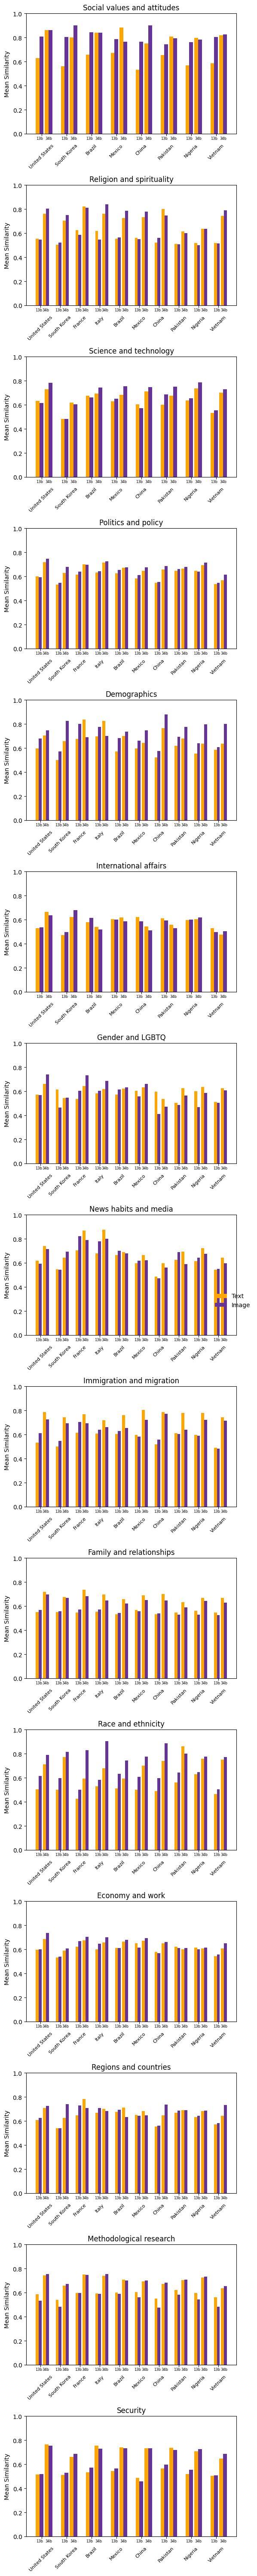

In [9]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
from tqdm import tqdm

# Directory to save individual figures
individual_figures_dir = 'plots/individual_topic'
if os.path.exists(individual_figures_dir):
    shutil.rmtree(individual_figures_dir)
    print(f"Existed! Deleted {individual_figures_dir} directory")
os.makedirs(individual_figures_dir, exist_ok=True)

# List of unique question topics
question_topics = sorted(all_data_df['question_topic'].unique())
models = sorted(all_data_df['model_size'].unique())

# Prepare for plotting
n_cols = 1  # Number of subplots per row
n_rows = int(np.ceil(len(question_topics) / n_cols))

fig_width = 6 * n_cols
fig_height = 4 * n_rows
fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
axs = axs.flatten()  # Flatten the array of axes

# Loop through each topic to create subplots
for idx, topic in enumerate(question_topics):
    df_category = all_data_df[all_data_df['question_topic'] == topic]

    # Prepare DataFrame by calculating means for each combination of 'country', 'Image', and 'model_size'
    df_category.loc[:, 'Image'] = df_category['Image'].map({'False': False, 'True': True})
    
    # Calculate mean 'question_topic_mean_similarity' and 'md_sim_topic' per country, Image scenario, and model_size
    df_mean = df_category.groupby(['country', 'Image', 'model_size'])[['question_topic_country_mean_similarity', 'md_sim_topic']].mean().reset_index()

    # Pivot the data to have Image scenarios as columns (Text Similarity, Image Similarity, and Baseline)
    # df_pivot = df_mean.pivot_table(index=['country', 'model_size'], columns='Image', values='question_topic_country_mean_similarity').reset_index()
    # Pivot the data to have Image scenarios as columns (Text Similarity, Image Similarity, and Baseline)
    df_pivot = df_mean.pivot_table(
        index=['country', 'model_size'], 
        columns='Image', 
        values='question_topic_country_mean_similarity'
    ).reset_index()
    
    # Handle the three columns for baseline, text, and image similarity
    # Calculate Baseline Similarity
    baseline_similarity = df_mean[df_mean['Image'] == True].groupby(['country', 'model_size'])['md_sim_topic'].mean().reset_index()
    baseline_similarity = baseline_similarity.rename(columns={'md_sim_topic': 'Baseline Similarity'})

    # Merge Baseline Similarity with df_pivot
    df_pivot = df_pivot.merge(
        baseline_similarity, 
        on=['country', 'model_size'], 
        how='left'
    )
    
    # df_pivot['Baseline Similarity'] = df_pivot['Baseline Similarity'].fillna(0)  # or another appropriate value
    # df_pivot['Baseline Similarity'] = df_mean[df_mean['Image'] == True].groupby(['country', 'model_size'])['md_sim_topic'].mean().values

    # # Drop rows where 'Baseline Similarity' is NaN
    df_pivot = df_pivot.dropna(subset=['Baseline Similarity'])
    df_pivot = df_pivot.rename(columns={False: 'Text Similarity', True: 'Image Similarity'})

    # Ensure all similarity columns exist
    for col in ['Text Similarity', 'Image Similarity', 'Baseline Similarity']:
        if col not in df_pivot.columns:
            df_pivot[col] = np.nan
    
    # breakpoint()
    # Sort countries based on 'country_list'
    df_pivot['country'] = pd.Categorical(df_pivot['country'], categories=country_list, ordered=True)
    df_pivot = df_pivot.sort_values('country')

    # # Drop rows with missing data
    # df_pivot = df_pivot.dropna()
    
    # Create a MultiIndex of all possible combinations
    all_combinations = pd.MultiIndex.from_product(
        [country_list, models],
        names=['country', 'model_size']
    ).to_frame(index=False)

    # Merge with df_pivot to ensure all combinations are present
    df_pivot = all_combinations.merge(df_pivot, on=['country', 'model_size'], how='left')

    # Drop rows with missing data
    df_pivot = df_pivot.dropna()
    
    # Data for plotting
    countries = df_pivot['country'].unique()
    baseline_similarities = df_pivot['Baseline Similarity']
    text_similarities = df_pivot['Text Similarity']
    image_similarities = df_pivot['Image Similarity']
    
    x = np.arange(len(countries))  # Label locations
    width = 0.15  # Width of the bars for each model
    gap_between_models = 0.13  # A larger gap between the two models' sets of bars

    ax = axs[idx]
    
    bigf_has_plotted_text = False
    bigf_has_plotted_image = False
    # Loop through models and plot for each
    for model_idx, model in enumerate(models):
        df_model = df_pivot[df_pivot['model_size'] == model]
        
        # Align df_model to have all countries, but do not fill missing values
        df_model = df_model.set_index('country').reindex(countries).reset_index()
        
        # Drop rows where any of the similarity columns are NaN
        df_model = df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'])
        
        # Recalculate x based on the length of df_model
        x = np.arange(len(df_model))
        
        offset = model_idx * (width * 1.5 + gap_between_models)  # Offset between different models
    
        
        # Plot bars for baseline, text, and image similarity
        # ax.bar(x + offset - width, df_model['Baseline Similarity'], width, label=f'{model} - Baseline')
        if not bigf_has_plotted_text:
            ax.bar(x + offset, df_model['Text Similarity'], width, label='Text', color='orange')
            bigf_has_plotted_text = True
        else:
            ax.bar(x + offset, df_model['Text Similarity'], width, color='orange')
            
        if not bigf_has_plotted_image:
            ax.bar(x + offset + width, df_model['Image Similarity'], width, label=f'Image', color='rebeccapurple')
            bigf_has_plotted_image = True
        else:
            ax.bar(x + offset + width, df_model['Image Similarity'], width, color='rebeccapurple')
        
        # Add model name annotation below the group of bars
        for i in range(len(x)):
            # Calculate the center position for the model label
            center_position = x[i] + offset + width / 2
            ax.text(center_position, -0.02, model, ha='center', va='top', fontsize=6, color='black', transform=ax.get_xaxis_transform())  # Adjust position as needed

    
    # Compute the mean similarity for the topic using text-level data only
    text_mean = df_pivot['Text Similarity'].mean()
    
    # Plot horizontal red dashed line at text_mean
    # ax.axhline(text_mean, color='red', linestyle='--')

    # Annotate the mean value on the plot
    # ax.text(0.01, text_mean, f'{text_mean:.2f}', color='black', ha='left', va='bottom', transform=ax.get_yaxis_transform())
    
    # Remove prefix (e.g., 'A.', 'B.', etc.) from topic name
    topic_title = topic.split('.', 1)[-1].strip()
    
    # Add labels, title, and custom x-axis tick labels
    ax.set_ylabel('Mean Similarity')
    ax.set_title(f'{topic_title}')
    ax.set_xticks(x + width)  # Adjust x-axis to center
    ax.set_xticklabels(countries, rotation=45)  # Set x-tick labels (country names)
    ax.tick_params(axis='x', which='major', labelsize=8, pad=12)  # Adjust font size and appearance
    ax.set_ylim([0, 1])  # Set y-axis limits to [0, 1]
    
    # Create individual figure for the topic
    fig_individual, ax_individual = plt.subplots(figsize=(15, 4))
    
    # Set the width of each bar and define the number of models
    width = 0.15  # Set the width for the bars
    gap_between_models = 0.35  # A larger gap between the two models' sets of bars


    # To ensure only one legend entry per type (Text, Baseline, Image)
    has_plotted_text = False
    # has_plotted_baseline = False
    has_plotted_image = False


    for model_idx, model in enumerate(models):
        df_model = df_pivot[df_pivot['model_size'] == model]
        
        # Align df_model to have all countries, but do not fill missing values
        df_model = df_model.set_index('country').reindex(countries).reset_index()
        
        # Drop rows where any of the similarity columns are NaN
        df_model = df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'])
        
        # Recalculate x based on the length of df_model
        x = np.arange(len(df_model))
        
        # Calculate the offset to center the bars around each x-tick
        if model_idx == 0:
            offset = -gap_between_models / 2
        else:
            offset = gap_between_models / 2
        
        # Plot the Text bars
        if not has_plotted_text:
            ax_individual.bar(x + offset - width / 2, df_model['Text Similarity'], width, label='Text', color='orange')
            has_plotted_text = True
        else:
            ax_individual.bar(x + offset - width / 2, df_model['Text Similarity'], width, color='orange')

        # Plot the Image bars
        if not has_plotted_image:
            ax_individual.bar(x + offset + width / 2, df_model['Image Similarity'], width, label='Image', color='rebeccapurple')
            has_plotted_image = True
        else:
            ax_individual.bar(x + offset + width / 2, df_model['Image Similarity'], width, color='rebeccapurple')
        
        # Add model name annotation below the group of bars
        for i in range(len(x)):
            center_position = x[i] + offset + width / 2
            ax_individual.text(center_position, -0.05, model, ha='center', va='bottom', fontsize=6, color='black')
  
    # Add labels, title, and custom x-axis tick labels
    ax_individual.set_ylabel('Mean Similarity')
    ax_individual.set_title(f'{topic_title}')
    # Set x-ticks to be at the center of the groups of bars
    # The middle point of each set of bars is `x + offset` for the second model, so we can set the x-ticks for that
    x_tick_positions = x + gap_between_models / 2  # Centered at the midpoint of the grouped bars
    ax_individual.set_xticks(x_tick_positions)  # Set x-tick positions
    ax_individual.set_xticklabels(countries)  # Set x-tick labels (country names)
    ax_individual.tick_params(axis='x', which='major', labelsize=10, pad=12)  # Adjust font size and appearance
    # set y max limit to 1
    ax_individual.set_ylim([0, 1])
    ax_individual.yaxis.set_ticks(np.arange(0, 1.1, 0.1))  # Set y-axis ticks in steps of 0.1

    
    # Add legend to individual figure, located in the upper right corner outside the plot area
    ax_individual.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=6)
    
    # Adjust layout to make room for the legend
    fig_individual.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for the legend
    
    # Save individual figure
    fig_individual.savefig(os.path.join(individual_figures_dir, f'{topic_title}.png'), bbox_inches='tight')
    plt.close(fig_individual)  # Close the figure to free memory
    
# Remove empty subplots if any
for idx in range(len(question_topics), n_rows * n_cols):
    fig.delaxes(axs[idx])

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave less space on the right

# Add a single legend on the right
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 0.5), frameon=False)

# Save the final figure with all subplots
fig.savefig(f'{individual_figures_dir}/final_similarity_plot.png', bbox_inches='tight')

plt.show()


In [ ]:
# This for 3 models


# import os
# import shutil
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.transforms import blended_transform_factory
# from tqdm import tqdm

# # Directory to save individual figures
# individual_figures_dir = 'plots/individual_topic'
# if os.path.exists(individual_figures_dir):
#     shutil.rmtree(individual_figures_dir)
#     print(f"Existed! Deleted {individual_figures_dir} directory")
# os.makedirs(individual_figures_dir, exist_ok=True)

# # List of unique question topics
# question_topics = sorted(all_data_df['question_topic'].unique())
# models = sorted(all_data_df['model_size'].unique())

# # Ensure there are exactly three models
# if len(models) != 2:
#     raise ValueError("This script is configured to handle exactly three models. Please adjust accordingly.")

# # Prepare for plotting
# n_cols = 1  # Number of subplots per row
# n_rows = int(np.ceil(len(question_topics) / n_cols))

# fig_width = 6 * n_cols
# fig_height = 4 * n_rows
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
# axs = axs.flatten()  # Flatten the array of axes

# # Define bar width and gaps
# bar_width = 0.1  # Width of each individual bar
# similarity_gap = 0.02  # Gap between Text and Image bars within the same model
# model_gap = 0.3  # Gap between different models

# # Calculate total width occupied by all models for proper centering
# num_models = len(models)
# num_similarities = 2  # Text and Image

# # Total width per country group
# total_group_width = num_models * (num_similarities * bar_width + similarity_gap) - similarity_gap + (num_models - 1) * model_gap

# # Start offset to center the bars
# start_offset = -total_group_width / 2

# # Loop through each topic to create subplots
# for idx, topic in enumerate(question_topics):
#     df_category = all_data_df[all_data_df['question_topic'] == topic].copy()

#     # Convert 'Image' column to boolean
#     df_category['Image'] = df_category['Image'].map({'False': False, 'True': True})

#     # Calculate mean similarities
#     df_mean = df_category.groupby(['country', 'Image', 'model_size'])[['question_topic_country_mean_similarity', 'md_sim_topic']].mean().reset_index()

#     # Pivot the data to have Image scenarios as columns
#     df_pivot = df_mean.pivot_table(
#         index=['country', 'model_size'], 
#         columns='Image', 
#         values='question_topic_country_mean_similarity'
#     ).reset_index()

#     # Calculate Baseline Similarity
#     baseline_similarity = df_mean[df_mean['Image'] == True].groupby(['country', 'model_size'])['md_sim_topic'].mean().reset_index()
#     baseline_similarity = baseline_similarity.rename(columns={'md_sim_topic': 'Baseline Similarity'})

#     # Merge Baseline Similarity with pivoted data
#     df_pivot = df_pivot.merge(
#         baseline_similarity, 
#         on=['country', 'model_size'], 
#         how='left'
#     )

#     # Drop rows with NaN Baseline Similarity
#     df_pivot = df_pivot.dropna(subset=['Baseline Similarity'])
#     df_pivot = df_pivot.rename(columns={False: 'Text Similarity', True: 'Image Similarity'})

#     # Ensure all similarity columns exist
#     for col in ['Text Similarity', 'Image Similarity', 'Baseline Similarity']:
#         if col not in df_pivot.columns:
#             df_pivot[col] = np.nan

#     # Sort countries based on 'country_list'
#     df_pivot['country'] = pd.Categorical(df_pivot['country'], categories=country_list, ordered=True)
#     df_pivot = df_pivot.sort_values('country')

#     # Create a MultiIndex of all possible combinations
#     all_combinations = pd.MultiIndex.from_product(
#         [country_list, models],
#         names=['country', 'model_size']
#     ).to_frame(index=False)

#     # Merge to ensure all combinations are present
#     df_pivot = all_combinations.merge(df_pivot, on=['country', 'model_size'], how='left')

#     # Drop rows with missing data
#     df_pivot = df_pivot.dropna()

#     # Data for plotting
#     countries = df_pivot['country'].unique()
#     num_countries = len(countries)
#     x = np.arange(num_countries)  # Label locations

#     ax = axs[idx]

#     # Flags to ensure legends are only created once
#     has_plotted_text = False
#     has_plotted_image = False

#     # Loop through models and plot for each
#     for model_idx, model in enumerate(models):
#         df_model = df_pivot[df_pivot['model_size'] == model]

#         # Align df_model to have all countries
#         df_model = df_model.set_index('country').reindex(countries).reset_index()

#         # Drop rows with missing similarity data
#         df_model = df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'])

#         # Calculate offset for the current model
#         offset = start_offset + model_idx * (num_similarities * bar_width + similarity_gap + model_gap)

#         # Plot Text Similarity bars
#         if not has_plotted_text:
#             ax.bar(x + offset, df_model['Text Similarity'], bar_width, label='Text', color='orange')
#             has_plotted_text = True
#         else:
#             ax.bar(x + offset, df_model['Text Similarity'], bar_width, color='orange')

#         # Plot Image Similarity bars
#         if not has_plotted_image:
#             ax.bar(x + offset + bar_width + similarity_gap, df_model['Image Similarity'], bar_width, label='Image', color='rebeccapurple')
#             has_plotted_image = True
#         else:
#             ax.bar(x + offset + bar_width + similarity_gap, df_model['Image Similarity'], bar_width, color='rebeccapurple')

#         # Add model name annotation below the group of bars
#         for i in range(num_countries):
#             center_position = x[i] + offset + (bar_width + similarity_gap) / 2
#             ax.text(center_position, -0.02, model, ha='center', va='top', fontsize=6, color='black', transform=ax.get_xaxis_transform())

#     # Remove prefix from topic name
#     topic_title = topic.split('.', 1)[-1].strip()

#     # Add labels, title, and custom x-axis tick labels
#     ax.set_ylabel('Mean Similarity')
#     ax.set_title(f'{topic_title}')
#     ax.set_xticks(x)  # Positions are already set by x
#     ax.set_xticklabels(countries, rotation=45, ha='right')  # Set x-tick labels (country names)
#     ax.tick_params(axis='x', which='major', labelsize=8, pad=12)  # Adjust font size and appearance
#     ax.set_ylim([0, 1])  # Set y-axis limits to [0, 1]

#     # Create individual figure for the topic
#     fig_individual, ax_individual = plt.subplots(figsize=(15, 4))

#     # Flags to ensure legends are only created once
#     has_plotted_text_individual = False
#     has_plotted_image_individual = False

#     for model_idx, model in enumerate(models):
#         df_model = df_pivot[df_pivot['model_size'] == model]

#         # Align df_model to have all countries
#         df_model = df_model.set_index('country').reindex(countries).reset_index()

#         # Drop rows with missing similarity data
#         df_model = df_model.dropna(subset=['Text Similarity', 'Image Similarity', 'Baseline Similarity'])

#         # Calculate offset for the current model
#         offset_individual = start_offset + model_idx * (num_similarities * bar_width + similarity_gap + model_gap)

#         # Plot Text Similarity bars
#         if not has_plotted_text_individual:
#             ax_individual.bar(x + offset_individual, df_model['Text Similarity'], bar_width, label='Text', color='orange')
#             has_plotted_text_individual = True
#         else:
#             ax_individual.bar(x + offset_individual, df_model['Text Similarity'], bar_width, color='orange')

#         # Plot Image Similarity bars
#         if not has_plotted_image_individual:
#             ax_individual.bar(x + offset_individual + bar_width + similarity_gap, df_model['Image Similarity'], bar_width, label='Image', color='rebeccapurple')
#             has_plotted_image_individual = True
#         else:
#             ax_individual.bar(x + offset_individual + bar_width + similarity_gap, df_model['Image Similarity'], bar_width, color='rebeccapurple')

#         # Add model name annotation below the group of bars
#         for i in range(num_countries):
#             center_position_individual = x[i] + offset_individual + (bar_width + similarity_gap) / 2
#             ax_individual.text(center_position_individual, -0.05, model, ha='center', va='bottom', fontsize=6, color='black')

#     # Add labels, title, and custom x-axis tick labels
#     ax_individual.set_ylabel('Mean Similarity')
#     ax_individual.set_title(f'{topic_title}')
#     ax_individual.set_xticks(x)  # Positions are already set by x
#     ax_individual.set_xticklabels(countries, rotation=45, ha='right')  # Set x-tick labels (country names)
#     ax_individual.tick_params(axis='x', which='major', labelsize=10, pad=12)  # Adjust font size and appearance
#     ax_individual.set_ylim([0, 1])  # Set y-axis limits to [0, 1]
#     ax_individual.yaxis.set_ticks(np.arange(0, 1.1, 0.1))  # Set y-axis ticks in steps of 0.1

#     # Add legend to individual figure, located in the upper right corner outside the plot area
#     ax_individual.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, fontsize=6)

#     # Adjust layout to make room for the legend
#     fig_individual.tight_layout(rect=[0, 0, 0.8, 1])  # Leave space on the right for the legend

#     # Save individual figure
#     fig_individual.savefig(os.path.join(individual_figures_dir, f'{topic_title}.png'), bbox_inches='tight')
#     plt.close(fig_individual)  # Close the figure to free memory

# # Remove empty subplots if any
# for idx in range(len(question_topics), n_rows * n_cols):
#     fig.delaxes(axs[idx])

# # Adjust layout to make room for the legend
# plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave less space on the right

# # Add a single legend on the right
# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.0, 0.5), frameon=False)

# # Save the final figure with all subplots
# fig.savefig(os.path.join(individual_figures_dir, 'final_similarity_plot.png'), bbox_inches='tight')


# plt.show()


### Variance (Difference) of Mean Similarities

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns


# df = all_data_df.copy() 
# # Mean similarity when Image is True
# mean_sim_with_image = df[df['Image'] == 'True'].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
# mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)

# # Mean similarity when Image is False
# mean_sim_without_image = df[df['Image'] == 'False'].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
# mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)

# # Step 2: Merge the two DataFrames on 'img_category' and 'country'
# mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['img_category', 'country'], how='inner')

# # Step 3: Calculate the variance (difference)
# mean_sim['variance'] = mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']

# # Step 4: Pivot the DataFrame to create the matrix with categories on y-axis and countries on x-axis
# variance_pivot = mean_sim.pivot(index='img_category', columns='country', values='variance')

# # Optional: Handle missing values in the pivot table
# variance_pivot.fillna(0, inplace=True)

# # Step 5: Plot the variance map using seaborn heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(variance_pivot, annot=True, fmt=".2f", cmap='coolwarm', center=0)

# # Customizing the plot
# plt.title('Variance of Mean Similarity Between Image Presence and Absence\n(Mean Similarity With Image - Mean Similarity Without Image)')
# plt.ylabel('Image Category')
# plt.xlabel('Country')

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45, ha='right')

# plt.tight_layout()
# plt.show()

### Percentage Change in Mean Similarities


This works with 2 models

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# df = all_data_df.copy()
# # Ensure 'Image' column is boolean
# df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# # Get the list of unique model sizes
# model_sizes = df['model_size'].unique()

# # Loop over each model size and generate the heatmap
# for model in model_sizes:
#     # Filter the DataFrame for the current model size
#     df_model = df[df['model_size'] == model]

#     # Step 1: Compute mean similarities with and without images for the current model size

#     # Mean similarity when Image is True
#     mean_sim_with_image = df_model[df_model['Image'] == True].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
#     mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)
    
#     # Mean similarity when Image is False
#     mean_sim_without_image = df_model[df_model['Image'] == False].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
#     mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)
    
#     # Step 2: Merge the two DataFrames
#     mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['img_category', 'country'], how='inner')
    
#     # Step 3: Calculate percentage change
#     # Avoid division by zero by replacing zeros in the denominator
#     epsilon = 1e-6
#     mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)
    
#     mean_sim['percentage_change'] = ((mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']) / mean_sim['mean_sim_without_image']) * 100
    
#     # Step 4: Pivot the DataFrame
#     percentage_change_pivot = mean_sim.pivot(index='img_category', columns='country', values='percentage_change')
    
#     # Optional: Handle infinite values and missing data
#     percentage_change_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
#     # replace NaN with 0
#     percentage_change_pivot.fillna(0, inplace=True)
#     # Clip the data to be within 0% to 100%
#     # percentage_change_pivot_clipped = percentage_change_pivot.clip(lower=0, upper=100)
    
#     # Step 5: Plot the heatmap with color bar from 0% to 100%
#     plt.figure(figsize=(8, 4))
#     sns.heatmap(
#         percentage_change_pivot,
#         annot=True,
#         fmt=".1f",
#         cmap='RdYlGn',
#         vmin=-20,
#         vmax=20,
#         cbar_kws={'label': 'Percentage Change (%)'},
#         annot_kws={"size": 6}  # Change the size of the numbers in the heatmap
#     )
    
#     # Customizing the plot
#     plt.title(f'Percentage Change in Mean Similarity Due to Image Presence\nModel Size: {model}', fontsize=8)
#     plt.ylabel('Image Category', fontsize=8)
#     plt.xlabel('Country', fontsize=8)
#     plt.yticks(ticks=np.arange(len(percentage_change_pivot.index)), labels=[label.replace('_', ' ').lower() for label in percentage_change_pivot.index])
    
#     # Rotate x-axis labels
#     plt.xticks(rotation=45, ha='right', fontsize=8)
#     plt.yticks(fontsize=8)
    
#     plt.tight_layout()
#     plt.savefig(f'plots/percentage_change_heatmap_category_{model}.png', bbox_inches='tight', dpi=500)
#     plt.show()


Fixed version of working with 2 model - GPT help

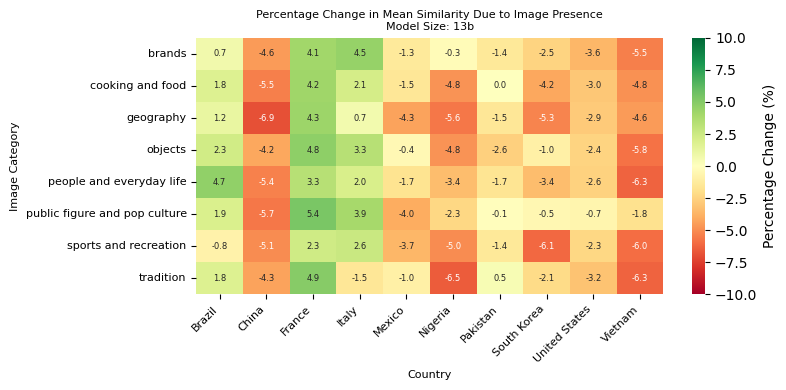

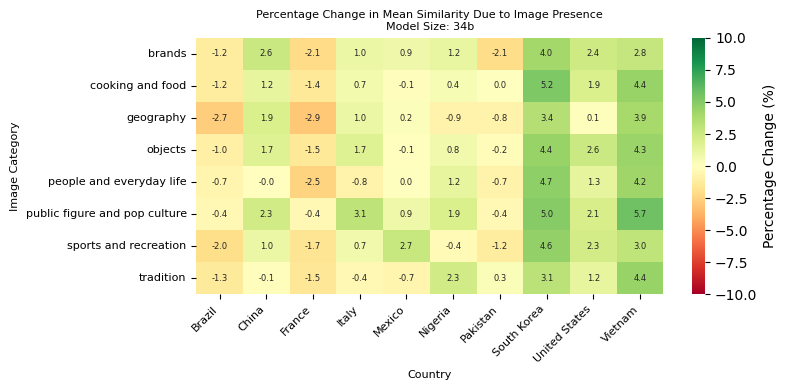

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = all_data_df.copy()
# Ensure 'Image' column is boolean
df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# Get the list of unique model sizes
model_sizes = df['model_size'].unique()

# Loop over each model size and generate the heatmap
for model in model_sizes:
    # Filter the DataFrame for the current model size
    df_model = df[df['model_size'] == model]

    # Step 1: Compute mean similarities with and without images for the current model size

    # Mean similarity when Image is True
    mean_sim_with_image = df_model[df_model['Image'] == True].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
    mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)
    
    # Mean similarity when Image is False
    mean_sim_without_image = df_model[df_model['Image'] == False].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
    mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)
    
    # Step 2: Merge the two DataFrames using an inner join (consistent with previous code)
    mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['img_category', 'country'], how='inner')
    
    # Step 3: Calculate percentage change
    # Avoid division by zero by replacing zeros in the denominator unconditionally (as in previous code)
    epsilon = 1e-6
    mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)
    
    mean_sim['percentage_change'] = ((mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']) / mean_sim['mean_sim_without_image']) * 100
    
    # Step 4: Pivot the DataFrame
    percentage_change_pivot = mean_sim.pivot(index='img_category', columns='country', values='percentage_change')
    
    # Optional: Handle infinite values and missing data
    percentage_change_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
    percentage_change_pivot.fillna(0, inplace=True)
    
    # Step 5: Plot the heatmap with consistent parameters
    plt.figure(figsize=(8, 4))
    sns.heatmap(
        percentage_change_pivot,
        annot=True,
        fmt=".1f",
        cmap='RdYlGn',
        vmin=-10,
        vmax=10,
        cbar_kws={'label': 'Percentage Change (%)'},
        annot_kws={"size": 6}  # Adjust the size as needed
    )
    
    # Customizing the plot
    plt.title(f'Percentage Change in Mean Similarity Due to Image Presence\nModel Size: {model}', fontsize=8)
    plt.ylabel('Image Category', fontsize=8)
    plt.xlabel('Country', fontsize=8)
    plt.yticks(
        ticks=np.arange(len(percentage_change_pivot.index)) + 0.5,
        labels=[label.replace('_', ' ').lower() for label in percentage_change_pivot.index],
        rotation=0,
        fontsize=8
    )
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.tight_layout()
    plt.savefig(f'plots/percentage_change_heatmap_category_{model}.png', bbox_inches='tight', dpi=500)
    plt.show()


Should work with 3 model

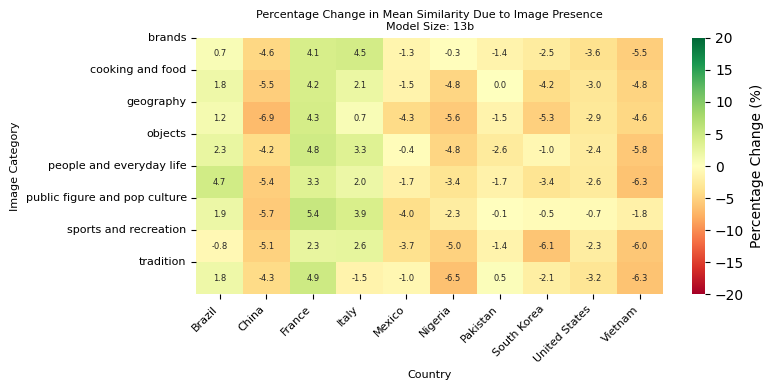

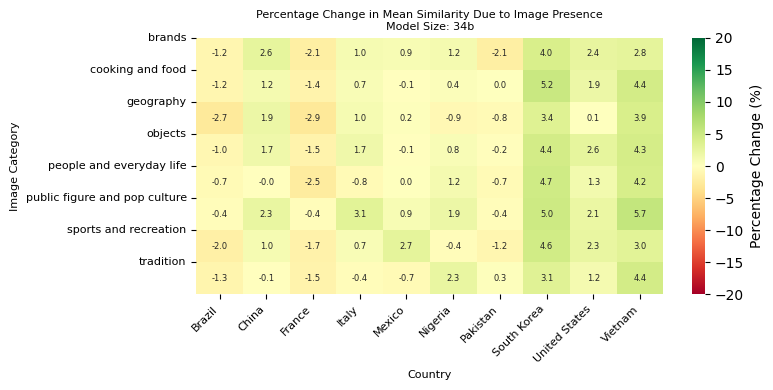

In [ ]:
# # This should also work

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# df = all_data_df.copy()
# # Ensure 'Image' column is boolean
# df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# # Get the list of unique model sizes
# model_sizes = df['model_size'].unique()

# # Loop over each model size and generate the heatmap
# for model in model_sizes:
#     # Filter the DataFrame for the current model size
#     df_model = df[df['model_size'] == model]

#     # Step 1: Compute mean similarities with and without images for the current model size

#     # Mean similarity when Image is True
#     mean_sim_with_image = df_model[df_model['Image'] == True].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
#     mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)
    
#     # Mean similarity when Image is False
#     mean_sim_without_image = df_model[df_model['Image'] == False].groupby(['img_category', 'country'])['similarity'].mean().reset_index()
#     mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)
    
#     # Step 2: Merge the two DataFrames
#     mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['img_category', 'country'], how='inner')
    
#     # Step 3: Calculate percentage change
#     # Avoid division by zero by replacing zeros in the denominator
#     epsilon = 1e-6
#     mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)
    
#     mean_sim['percentage_change'] = ((mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']) / mean_sim['mean_sim_without_image']) * 100
    
#     # Step 4: Pivot the DataFrame
#     percentage_change_pivot = mean_sim.pivot(index='img_category', columns='country', values='percentage_change')
    
#     # Optional: Handle infinite values and missing data
#     percentage_change_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
#     # replace NaN with 0
#     percentage_change_pivot.fillna(0, inplace=True)
#     # Clip the data to be within 0% to 100%
#     # percentage_change_pivot_clipped = percentage_change_pivot.clip(lower=0, upper=100)
    
#     # Step 5: Plot the heatmap with color bar from 0% to 100%
#     plt.figure(figsize=(8, 4))
#     sns.heatmap(
#         percentage_change_pivot,
#         annot=True,
#         fmt=".1f",
#         cmap='RdYlGn',
#         vmin=-20,
#         vmax=20,
#         cbar_kws={'label': 'Percentage Change (%)'},
#         annot_kws={"size": 6}  # Change the size of the numbers in the heatmap
#     )
    
#     # Customizing the plot
#     plt.title(f'Percentage Change in Mean Similarity Due to Image Presence\nModel Size: {model}', fontsize=8)
#     plt.ylabel('Image Category', fontsize=8)
#     plt.xlabel('Country', fontsize=8)
#     plt.yticks(ticks=np.arange(len(percentage_change_pivot.index)), labels=[label.replace('_', ' ').lower() for label in percentage_change_pivot.index])
    
#     # Rotate x-axis labels
#     plt.xticks(rotation=45, ha='right', fontsize=8)
#     plt.yticks(fontsize=8)
    
#     plt.tight_layout()
#     plt.savefig(f'plots/percentage_change_heatmap_category_{model}.png', bbox_inches='tight', dpi=500)
#     plt.show()


### Ratio of Mean Similarities


In [ ]:
# # Create a cross-join to see all possible combinations of question_topic and country
# all_combinations = pd.MultiIndex.from_product([mean_sim['question_topic'].unique(), 
#                                                mean_sim['country'].unique()], 
#                                                names=['question_topic', 'country'])

# # Reindex mean_sim to find missing combinations
# reindexed_mean_sim = mean_sim.set_index(['question_topic', 'country']).reindex(all_combinations).reset_index()

# # Find rows where percentage_change is NaN (missing combinations)
# missing_combinations = reindexed_mean_sim[reindexed_mean_sim['percentage_change'].isna()]
# print("Missing combinations of 'question_topic' and 'country':")
# print(missing_combinations[['question_topic', 'country']])


### Percntage Change in Mean Similarities at Question Topic level

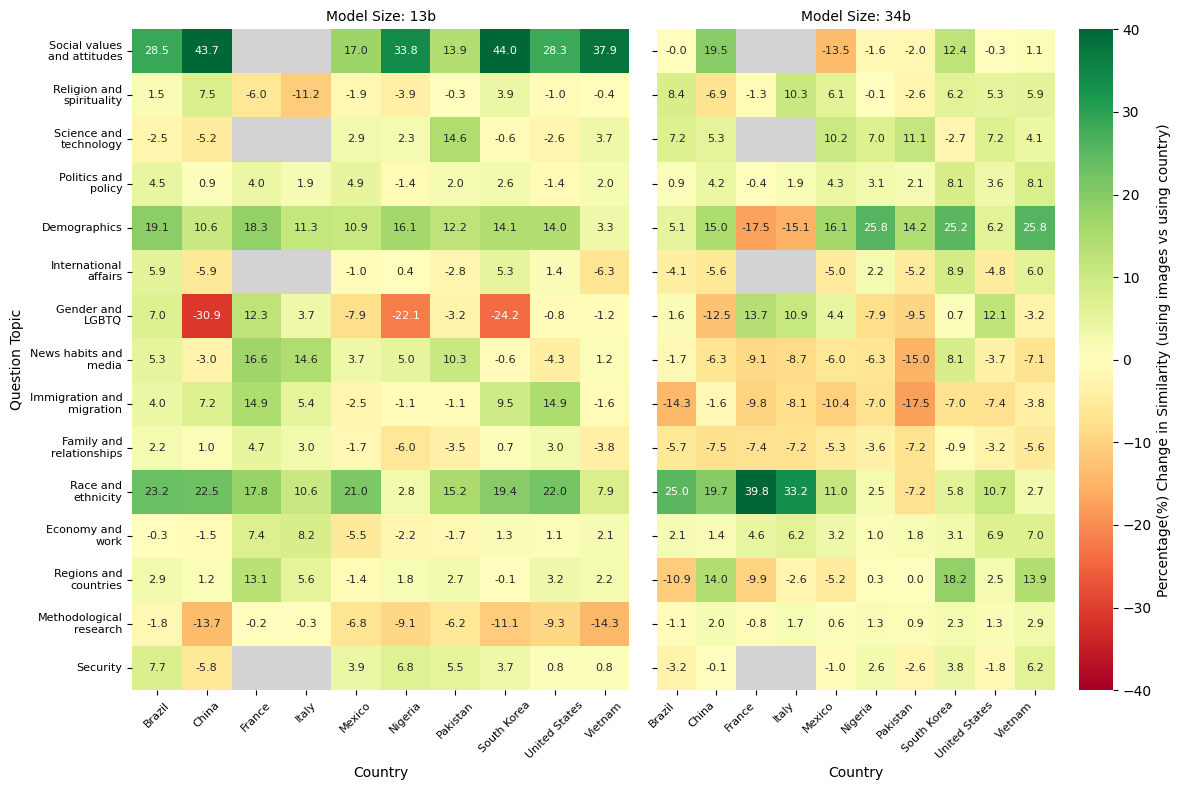

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from textwrap import wrap

df = all_data_df.copy()
# Ensure 'Image' column is boolean
df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# Get the list of unique model sizes
model_sizes = df['model_size'].unique()

# Adjust figure size based on the number of question topics
num_topics = df['question_topic'].nunique()
fig_height = max(8, num_topics * 0.01)

# fig_height = 6
# Create a figure with subplots
fig, axes = plt.subplots(1, len(model_sizes), figsize=(12, fig_height), sharey=True)

# Loop over each model size and generate the heatmap
for idx, model in enumerate(model_sizes):
    # Filter the DataFrame for the current model size
    df_model = df[df['model_size'] == model]

    # Compute mean similarities with and without images
    mean_sim_with_image = df_model[df_model['Image'] == True].groupby(['question_topic', 'country'])['similarity'].mean().reset_index()
    mean_sim_with_image.rename(columns={'similarity': 'mean_sim_with_image'}, inplace=True)
    
    mean_sim_without_image = df_model[df_model['Image'] == False].groupby(['question_topic', 'country'])['similarity'].mean().reset_index()
    mean_sim_without_image.rename(columns={'similarity': 'mean_sim_without_image'}, inplace=True)
    
    # Merge the two DataFrames
    mean_sim = pd.merge(mean_sim_with_image, mean_sim_without_image, on=['question_topic', 'country'], how='inner')
    
    # Calculate percentage change
    epsilon = 1e-6
    mean_sim['mean_sim_without_image'].replace(0, epsilon, inplace=True)
    mean_sim['percentage_change'] = ((mean_sim['mean_sim_with_image'] - mean_sim['mean_sim_without_image']) / mean_sim['mean_sim_without_image']) * 100
    
    # Pivot the DataFrame
    breakpoint()
    percentage_change_pivot = mean_sim.pivot(index='question_topic', columns='country', values='percentage_change')
    # percentage_change_pivot = mean_sim.pivot(index='country', columns='question_topic', values='percentage_change')
    
    # Handle infinite values and missing data
    percentage_change_pivot.replace([np.inf, -np.inf], np.nan, inplace=True)
    # percentage_change_pivot.fillna(0, inplace=True)
    # percentage_change_pivot_clipped = percentage_change_pivot.clip(lower=0, upper=100)
    percentage_change_pivot_clipped = percentage_change_pivot
    
    # Define a colormap with grey for NaN values
    cmap = sns.diverging_palette(240, 10, as_cmap=True)  # RdYlGn-like colormap
    cmap = plt.get_cmap('RdYlGn')  # Get the RdYlGn colormap
    cmap.set_bad(color='lightgrey')  # Set color for NaN values
    
    # Plot the heatmap in the subplot
    sns.heatmap(
        percentage_change_pivot_clipped,
        annot=True,
        fmt=".1f",
        cmap=cmap,
        vmin=-40,
        vmax=40,
        cbar=(idx == len(model_sizes) - 1),  # Show color bar only on the last subplot
        ax=axes[idx],
        cbar_kws={'label': 'Percentage(%) Change in Similarity (using images vs using country)'} if idx == len(model_sizes) - 1 else None,
        annot_kws={"size": 8},
        mask=percentage_change_pivot_clipped.isna(),  # Mask NaN values
    )
    
    # Customize the subplot
    axes[idx].set_title(f'Model Size: {model}', fontsize=10)
    axes[idx].set_xlabel('Country')
    if idx == 0:
        axes[idx].set_ylabel('Question Topic')
    else:
        axes[idx].set_ylabel('')
    
    # Rotate x-axis labels
    axes[idx].tick_params(axis='x', rotation=45, labelsize=8)
    # Adjust y-axis labels font size
    axes[idx].tick_params(axis='y', labelsize=8)

    # Adjust wrap width based on label length
    wrapped_labels = ['\n'.join(wrap(label.split('. ', 1)[-1], 15)) for label in percentage_change_pivot_clipped.index]
    axes[idx].set_yticklabels(wrapped_labels, fontsize=8, rotation=0)
    

plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('plots/percentage_change_heatmap_topic_models.png', bbox_inches='tight', dpi=500)
plt.show()


### Compute average similarity for each country with and withour images

In [ ]:
all_data_df.columns

Index(['img_id', 'image_path', 'country', 'image_code', 'income',
       'question_text', 'country_prompt', 'generic_prompt', 'option_labels',
       'full_options', 'prompt', 'options', 'top10_token_prob',
       'prob_percent_sorted', 'sum_prob_percent_sorted', 'prob_percent_keys',
       'prob_percent_values', 'selection_answers', 'img_category', 'jsd',
       'similarity', 'Image', 'model_size', 'country_mean_jsd',
       'coutry_mean_similarity', 'question_topic', 'question_topic_mean_jsd',
       'question_topic_mean_similarity',
       'question_topic_country_mean_similarity', 'md_topic_pred',
       'md_topic_gt', 'md_all_pred', 'md_all_gt', 'md_jsd_topic',
       'md_sim_topic', 'md_jsd_overall', 'md_sim_overall'],
      dtype='object')

In [ ]:
import pandas as pd

# Assuming your DataFrame is named df and includes the columns:
# 'question_text', 'country', 'similarity', 'Image', and 'model'

df = all_data_df.copy()

# Step 1: Group by 'country', 'model', and 'Image' to calculate the mean similarity
mean_similarity = df.groupby(['model_size', 'Image', 'country', 'question_text'])['similarity'].mean().reset_index()
mean_similarity['similarity'] = mean_similarity['similarity'].round(2)

# Step 2: Pivot the DataFrame to have countries as columns and 'Image' as rows
mean_similarity_pivot = mean_similarity.pivot_table(
    index=['model_size', 'Image'],
    columns='country',
    values='similarity'
).reset_index()

# rename Image column to Condition. Map True to 'Image (no country name)' and False to 'Country name (no image)'
mean_similarity_pivot['Condition'] = mean_similarity_pivot['Image'].map({'True': 'Image (no country name)', 'False': 'Country name (no image)'})
# Display the result
mean_similarity_pivot.drop(columns=['Image'], inplace=True)
mean_similarity_pivot.set_index(['model_size', 'Condition'], inplace=True)
mean_similarity_pivot


country                               Brazil     China    France     Italy  \
model_size Condition                                                         
13b        Country name (no image)  0.574360  0.531525  0.582087  0.585043   
           Image (no country name)  0.618341  0.605311  0.620609  0.635478   
34b        Country name (no image)  0.691848  0.680904  0.734870  0.716957   
           Image (no country name)  0.683128  0.689661  0.721652  0.722957   
72b        Country name (no image)  0.641238  0.666893  0.647913  0.660261   
           Image (no country name)  0.645403  0.654633  0.676087  0.683217   

country                               Mexico   Nigeria  Pakistan  South Korea  \
model_size Condition                                                            
13b        Country name (no image)  0.564155  0.564298  0.581571     0.515928   
           Image (no country name)  0.626393  0.648377  0.641857     0.584208   
34b        Country name (no image)  0.688082  0.698026  0.679429     0.649276   
           Image (no country name)  0.691416  0.703289  0.674429     0.677195   
72b        Country name (no image)  0.643991  0.688150  0.640335     0.627545   
           Image (no country name)  0.647169  0.671535  0.639381     0.642986   

country                             United States   Vietnam  
model_size Condition                                         
13b        Country name (no image)       0.555762  0.522488  
           Image (no country name)       0.624286  0.587416  
34b        Country name (no image)       0.730238  0.634880  
           Image (no country name)       0.743000  0.660813  
72b        Country name (no image)       0.680718  0.626250  
           Image (no country name)       0.702952  0.625072

#### Plot on world map

Global Min: -2.415025645704455, Global Max: 14.967615822047115


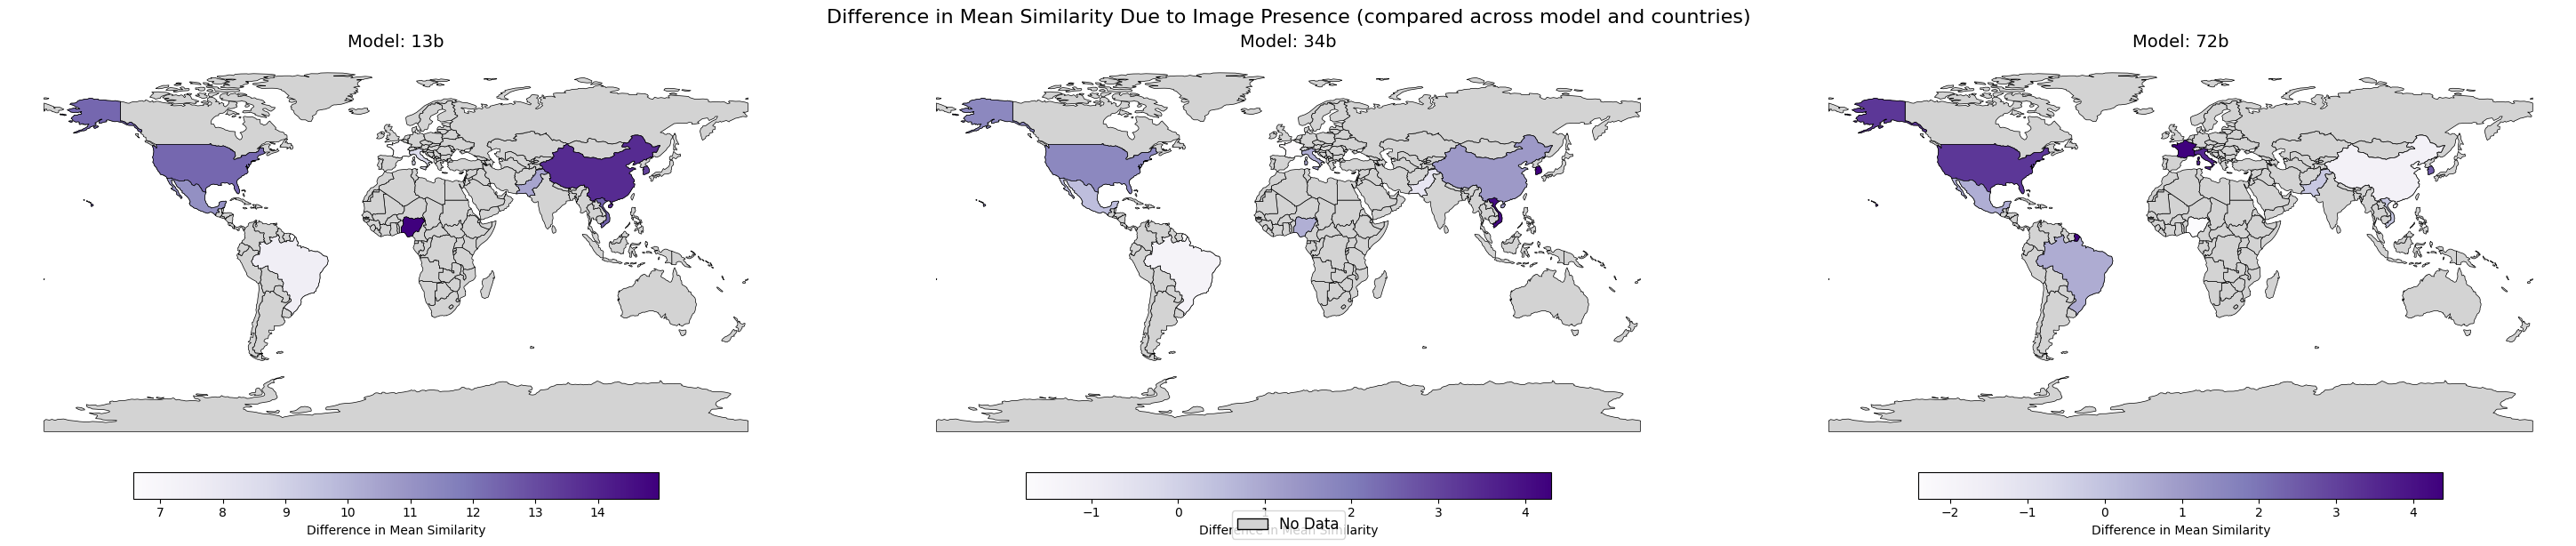

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
import matplotlib.patches as mpatches

# ---------------------------
# Step 1: Prepare the Data
# ---------------------------

# Assume all_data_df is your initial DataFrame
df = all_data_df.copy()

# Ensure 'Image' column is boolean
df['Image'] = df['Image'].map({'True': True, 'False': False}).astype(bool)

# Calculate mean similarity for each combination of 'model_size', 'Image', and 'country'
mean_similarity = df.groupby(['model_size', 'Image', 'country'])['similarity'].mean().reset_index()

# Pivot the DataFrame to have separate columns for 'Image=True' and 'Image=False'
mean_similarity_pivot = mean_similarity.pivot_table(
    index=['model_size', 'country'],
    columns='Image',
    values='similarity'
).reset_index()

# Rename the pivoted columns for clarity
mean_similarity_pivot.rename(columns={
    True: 'mean_similarity_with_image',
    False: 'mean_similarity_without_image'
}, inplace=True)

# Calculate the difference in mean similarity (Image=True minus Image=False)
mean_similarity_pivot['difference'] = (
    mean_similarity_pivot['mean_similarity_with_image'] - 
    mean_similarity_pivot['mean_similarity_without_image']
)

# Calculate the percentage change in mean similarity
mean_similarity_pivot['percentage_change'] = (
    (mean_similarity_pivot['difference'] / mean_similarity_pivot['mean_similarity_without_image']) * 100
)

# ---------------------------
# Step 2: Map Country Names to ISO Alpha-3 Codes
# ---------------------------

def get_iso3(country_name):
    """Convert country names to their ISO Alpha-3 codes."""
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except:
        return None

mean_similarity_pivot['iso_a3'] = mean_similarity_pivot['country'].apply(get_iso3)


# Remove entries with missing ISO codes
mean_similarity_pivot.dropna(subset=['iso_a3'], inplace=True)

# ---------------------------
# Step 3: Load and Merge World Map Data
# ---------------------------

# Load the Natural Earth dataset
world = gpd.read_file('https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip')

# Merge your similarity difference data with the world GeoDataFrame on 'iso_a3'
merged = world.merge(mean_similarity_pivot, how='left', left_on='ADM0_A3', right_on='iso_a3')

# ---------------------------
# Step 4: Plot the Data on a World Map
# ---------------------------

# Get unique model sizes
models = mean_similarity_pivot['model_size'].unique()
n_models = len(models)

# Set up the figure with subplots for each model
fig, axes = plt.subplots(1, n_models, figsize=(10 * n_models, 6), constrained_layout=True)

# Ensure 'axes' is iterable
if n_models == 1:
    axes = [axes]

# Define the colormap: 'Purples' where dark purple indicates higher difference
cmap = 'Purples'

# Determine global min and max for consistent color scaling
global_min = merged['percentage_change'].min()
global_max = merged['percentage_change'].max()

print(f"Global Min: {global_min}, Global Max: {global_max}")

# Plot each model in a separate subplot
for ax, model in zip(axes, models):
    # Filter data for the current model
    model_data = merged[merged['model_size'] == model]
    
    # Plot all countries in light grey
    world.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5)
    
    # Plot countries with data using the 'Purples' colormap
    model_data.dropna(subset=['percentage_change']).plot(
        ax=ax,
        column='percentage_change',
        cmap=cmap,
        linewidth=0.5,
        edgecolor='black',
        legend=True,
        legend_kwds={
            'label': "Difference in Mean Similarity",
            'orientation': "horizontal",
            'shrink': 0.6,
            'pad': 0.05
        },
        vmin=model_data['percentage_change'].min(),
        vmax=model_data['percentage_change'].max()
    )
    
    # Set title and remove axes
    ax.set_title(f"Model: {model}", fontsize=14)
    ax.axis('off')

# Create a legend patch for "No Data"
no_data_patch = mpatches.Patch(facecolor='lightgrey', edgecolor='black', label='No Data')

# Add the "No Data" patch to the figure legend
fig.legend(handles=[no_data_patch], loc='lower center', ncol=1, fontsize=12)

# Add an overall title to the figure
fig.suptitle("Difference in Mean Similarity Due to Image Presence (compared across model and countries)", fontsize=16)
plt.savefig('plots/world_map.png', bbox_inches='tight')
# Show the plot
plt.show()


In [ ]:
mnp = merged[merged['percentage_change'].notna()]
mnp_pivot = mnp.pivot(index='model_size', columns='country', values='percentage_change')
mnp_pivot.sort_values(by=mnp_pivot.columns.tolist(), ascending=False)

country,Brazil,China,France,Italy,Mexico,Nigeria,Pakistan,South Korea,United States,Vietnam
model_size,,,,,,,,,,
13b,7.565674,13.805309,6.571983,8.565528,11.144643,14.967616,10.461564,13.199505,12.323506,12.462583
72b,0.541374,-1.830233,4.386765,3.511913,0.487885,-2.415026,-0.193183,2.452527,3.204111,-0.150530
34b,-1.327543,1.311885,-1.756037,0.870535,0.477360,0.816393,-0.733037,4.298559,1.720951,4.088651


In [ ]:
all_data_df['country'].unique()

array(['Brazil', 'China', 'France', 'Italy', 'Mexico', 'Nigeria',
       'Pakistan', 'South Korea', 'United States', 'Vietnam'],
      dtype=object)

### Missing row where NaN exists